In [1]:
"""
run_bayesian.py
Python script to run Bayesian analysis for DIUSST model
"""

# Change working directory to curr
import os

# Load external modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
from multiprocessing import Pool
from multiprocessing import cpu_count

# Load custom functions
from interpolation import cfl_interpolation5
from diusst_model5 import diusst_bayesian as diusst

# Time stamp
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%y%m%d-%H%M%S")

In [5]:
# Fit parameters
param_names = ['kappa', 'mu', 'attenu', 'kappa0', 'lambd']

# Parameter limits
param_min = np.array([0, 0, 1e-3, 0, 0.5])
param_max = np.array([7e-4, 0.1, 10, 1, 20])

# Initial walker positions
#param_start = np.array([0.3e-4, 1e-4, 2.5, 0.9, 1])
param_start = np.array([1e-4, 0.0096, 4.6, 0.01, 20])

# Sampling
nwalkers = 32
nsteps = 2000

# DIUSST model
scheme = 'euler'
z_f = 10
dz0 = 0.10
ngrid = 50
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10

# Dataset
data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_ssterr03-10_humid10.csv'
data_interval = [1149,1471]


In [6]:
# Load dataset
data_orig = pd.read_csv(data_path+data_filename)[data_interval[0]:data_interval[1]]

# interpolate to meet CFL condition
data, dtlist = cfl_interpolation5(data_orig, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=param_max[0], k_0_max=param_max[3], lambd_min=param_min[-1],
        maxwind=maxwind, z_f=z_f)

+++ Variable time-step interpolation +++
Interpolated dataset has 370313 time steps with average length 2.47 s.
Constant dt interpolation would require dt = 0.171 s --> 1677152 steps.
Computation time will be reduced by 77.92 %
++++++++++++++++++++++++++++++++++++++++


In [7]:
ftemp = np.mean(data['ftemp'].to_numpy(np.float64))
sst_data = data['sst'].to_numpy(np.float64) - data['ftemp'].to_numpy(np.float64)
sst_err = data['sst_err'].to_numpy(np.float64) * 0.01
times = data['times'].to_numpy(np.float64)
wind = data['wind'].to_numpy(np.float64)
atemp = data['atemp'].to_numpy(np.float64)
swrad = data['swrad'].to_numpy(np.float64)
humid = data['humid'].to_numpy(np.float64)

In [8]:
kappa, mu, attenu, kappa0, lambd = param_start
simu = diusst(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu, k_0=kappa0, lambd=lambd,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

In [33]:
kappa, mu, attenu, kappa0, lambd = [1e-4,0.005,2.5,0.8,10]

simu2 = diusst(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu, k_0=kappa0, lambd=lambd,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

# Plots

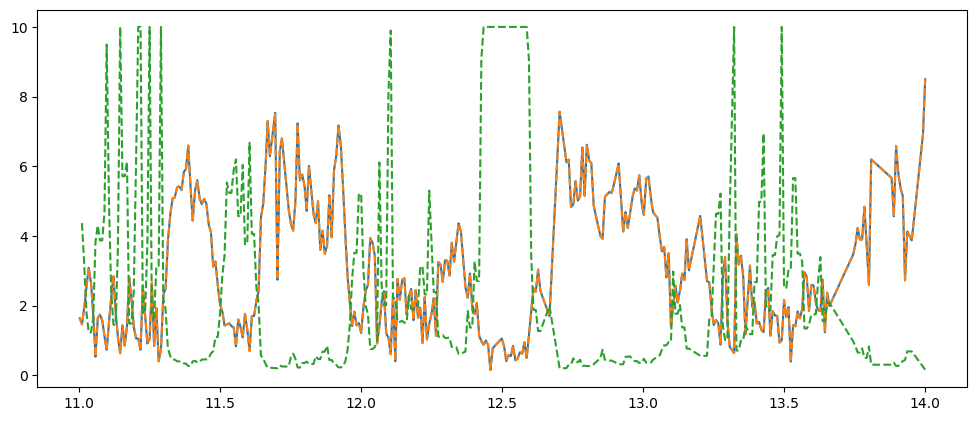

In [34]:
fig, ax = plt.subplots(dpi=100,figsize=(12,5))
ax.plot(data['times']/86400,data['wind'])
ax.plot(data_orig['times']/86400,data_orig['wind'],'--')
ax.plot(data_orig['times'][1:]/86400,dtlist,'--')
plt.show()


[Text(0.5, 1.0, 'SST-ftemp')]

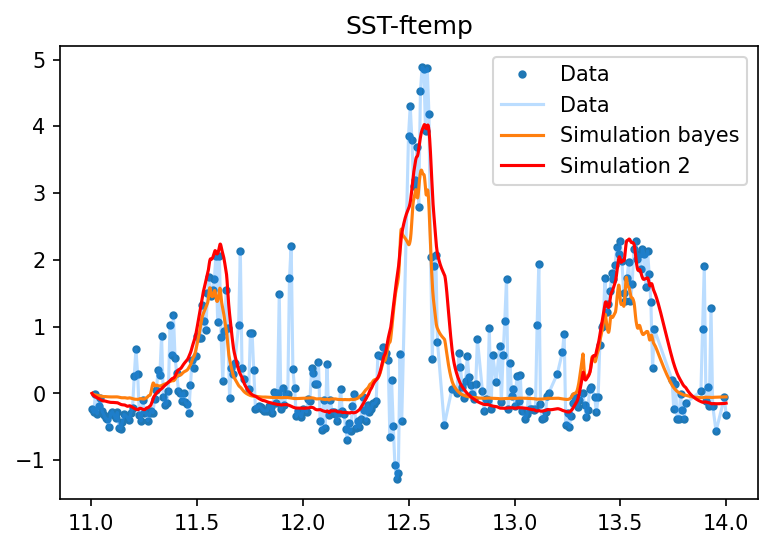

In [41]:
fig, ax = plt.subplots(dpi=150)
ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'], '.', label='Data')
ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'], '-', alpha=0.3,c='dodgerblue',label='Data')
ax.plot(times/86400,simu[0][:,0]-ftemp,label='Simulation bayes')
ax.plot(times/86400,simu2[0][:,0]-ftemp,label='Simulation 2',c='red')
ax.legend()
ax.set(title='SST-ftemp')

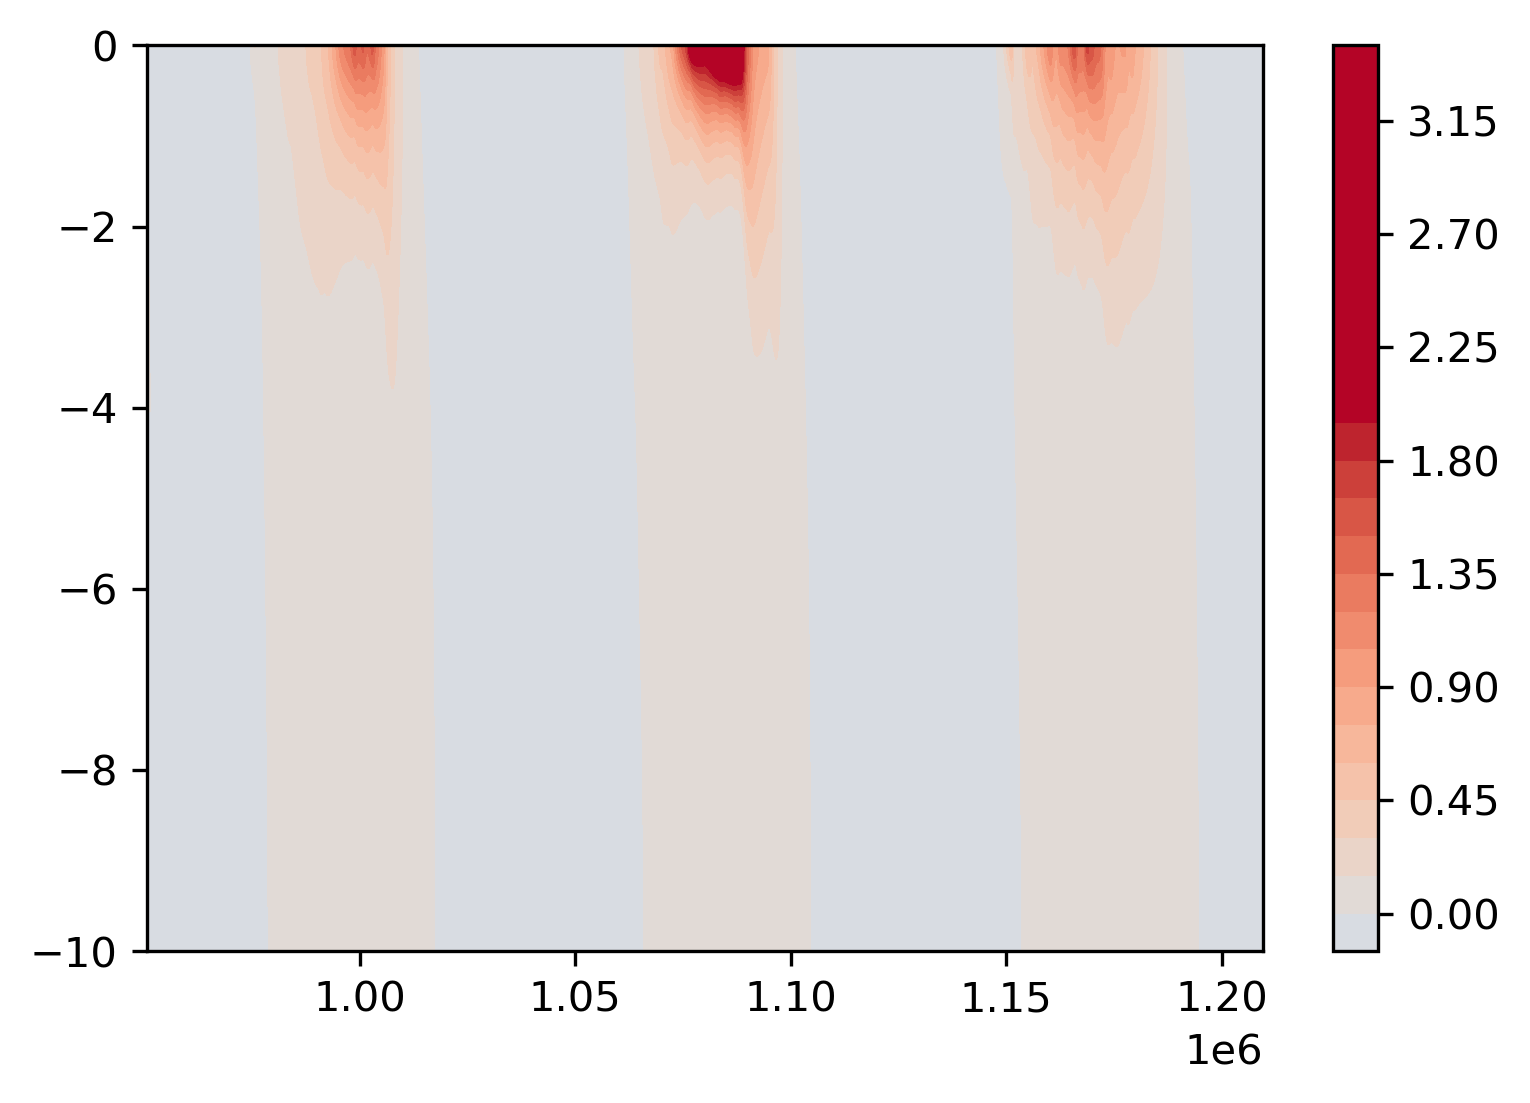

In [19]:
fig, ax = plt.subplots(dpi=300)
plot = ax.contourf(times,simu[1],simu[0].transpose()-ftemp,levels=30,cmap='coolwarm',vmin=-2,vmax=2)
fig.colorbar(plot)
plt.show()

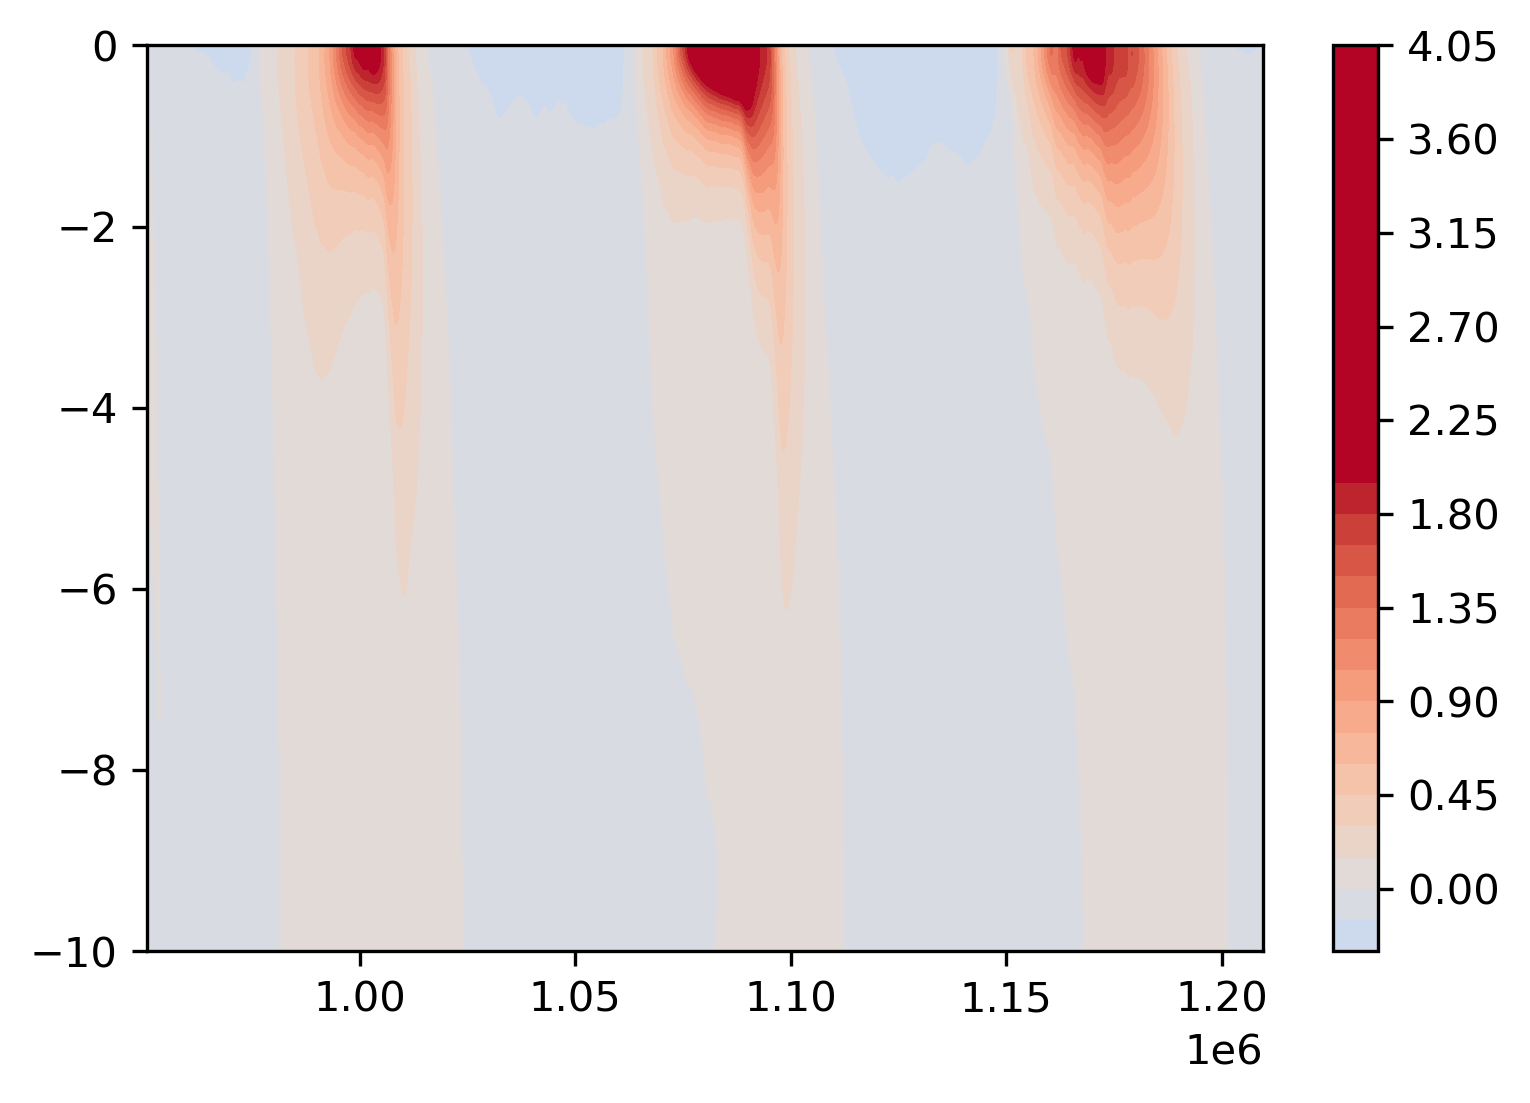

In [36]:
fig, ax = plt.subplots(dpi=300)
plot = ax.contourf(times,simu2[1],simu2[0].transpose()-ftemp,levels=30,cmap='coolwarm',vmin=-2,vmax=2)
fig.colorbar(plot)
plt.show()

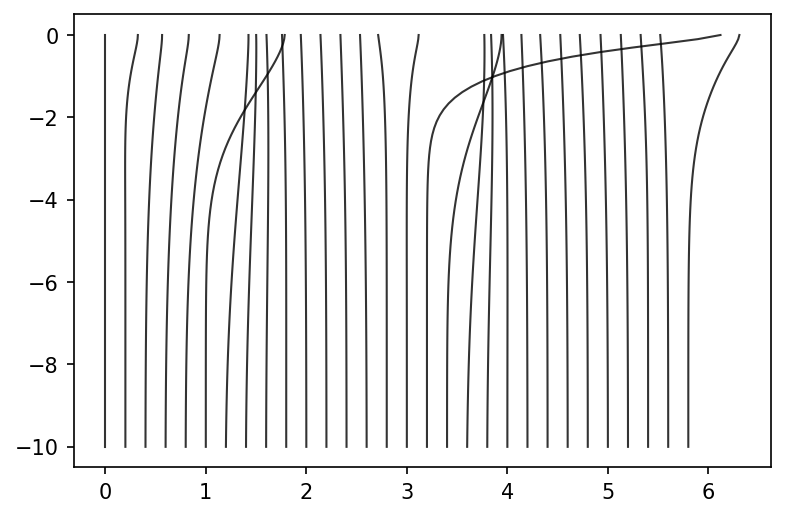

In [37]:
fig, ax = plt.subplots(dpi=150)
for i in range(30):
    ax.plot(simu[0][i*10000,:]+0.2*i-ftemp,simu[1],c='k',lw=1,alpha=0.8)

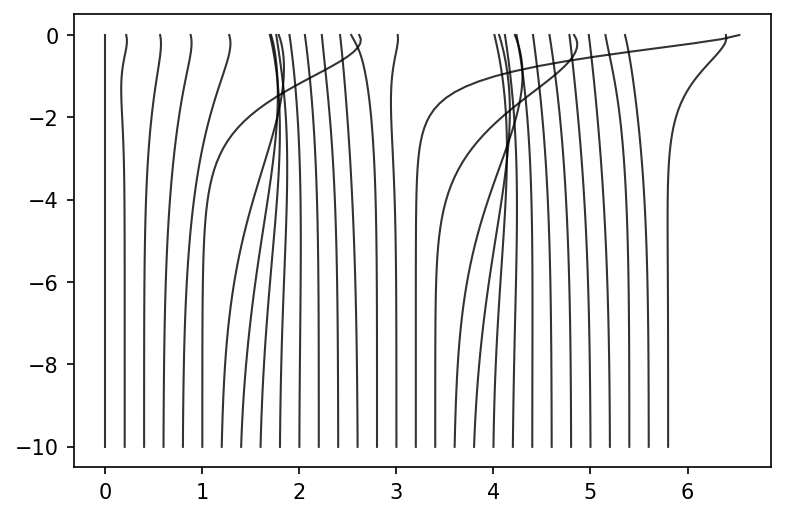

In [38]:
fig, ax = plt.subplots(dpi=150)
for i in range(30):
    ax.plot(simu2[0][i*10000,:]+0.2*i-ftemp,simu2[1],c='k',lw=1,alpha=0.8)